### <font color="black" size='3'><b>Grupo em ordem alfabética  </b></font>
<html>
<table border="1px">
<tr>
<td bgcolor="Aquamarine">Nome do Aluno</td>
<td bgcolor="Aquamarine">RA</td>
</tr>
<tr>
<td bgcolor="white">Alcir Canella Filho</td>
<td bgcolor="white">10396389</td>
</tr>
<tr>
<td bgcolor="white">Felipe Clé Monteiro</td>
<td bgcolor="white">10395521</td>
</tr>
    <tr>
<td bgcolor="white">Matheus Marques</td>
<td bgcolor="white">10395894</td>
</tr>
    </table>
</html>

# **Bibliotecas e Instalações**

In [1]:
%%capture 

!pip install shap
!pip install optuna
!pip install xgboost
!pip install lightgbm

In [3]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Qtde de núcleos da CPU

In [4]:
seed = 10 # semente para o random_state
# Básicas
import pandas as pd
import numpy as np
import plotly.express as px

# Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#Otimização Hiperparametros
import optuna
from optuna.samplers import RandomSampler
from optuna.visualization import plot_optimization_history

In [5]:
import sklearn
import xgboost
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', sklearn.__version__)
print('optuna:', optuna.__version__)
print('xgboost:', xgboost.__version__)

pandas: 2.2.2
numpy: 1.26.4
sklearn: 1.4.2
optuna: 4.1.0
xgboost: 2.1.2


In [6]:
#Arquivo separado com algumas funções mais complexas, para deixar este notebook mais organizado
from functions import *

# **Introdução**

**Ideia Geral**

Utilizando os dados de câncer da FOSP, selecionados para Câncer de Prostata, serão utilizados três modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida por cinco anos(Para o trabalho completo, serão utilizados todas as labels de tempo criadas, para este projeto utilizaremos apenas a de 5 anos).

> O label é 0 se o paciente não sobreviveu após cinco anos do diagnóstico e 1 se sobreviveu.

In [8]:
df= pd.read_csv('data_preProcess2.csv', sep = ',', encoding = 'UTF-8',low_memory=False)

In [9]:
df.shape

(44094, 37)

In [10]:
# Valores faltantes
df.isna().sum().sort_values(ascending=False).head(6)

ESCOLARI     0
NENHUMANT    0
CONSDIAG     0
TRATCONS     0
DIAGTRAT     0
ANODIAG      0
dtype: int64

In [11]:
# Correlação com a saída
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.794248
ULTICONS        0.786835
ULTITRAT        0.782832
vivo_ano3       0.703177
ANODIAG         0.432113
GLEASON         0.351457
PSA             0.348531
vivo_ano1       0.343955
G               0.212398
CATEATEND       0.196797
obito_cancer    0.178442
RECNENHUM       0.134996
ESCOLARI        0.134941
IBGEATEN        0.116982
DRS             0.101224
IDADE           0.097865
obito_geral     0.096171
CIRURGIA        0.093570
QUIMIO          0.088777
Name: vivo_ano5, dtype: float64

In [12]:
#Dados com valores categoricos.
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print(non_numeric_cols)


Index(['EC', 'TRATHOSP'], dtype='object')


In [13]:
# Quantidade de pacientes em cada classe da saída
df.vivo_ano5.value_counts()

vivo_ano5
1    23372
0    20722
Name: count, dtype: int64

## **DataFrame vivo_ano5**

 - Antes de realizar o pré-processamento dos dados é necessário filtrar os dados, de modo a retirar pacientes que não foram acompanhados por pelo **menos cinco** anos e que a última informação consta como vivos.
 - Nesta função realizamos alguns tipos de pre-processamentos, como principais podemos citar:(para mais detalhes consultar "functions.py")
     - Filtragem por intervalo de anos, no caso a coluna vivo_ano5 que escolhemos.
     - Divisão Treinamento/teste
     - Codificação e Normalização dos dados de treino e teste
     - Balanceamento: Usa SMOTE para balancear os dados de treinamento.
     - Seleção de features,etc...

In [15]:
# Seleção realizada abaixo:
df_ano5 = df[~((df.obito_geral == 0) & (df.vivo_ano5 == 0))].reset_index(drop=True)
df_ano5.shape

(31609, 37)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44094 entries, 0 to 44093
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ESCOLARI      44094 non-null  float64
 1   IDADE         44094 non-null  int64  
 2   IBGE          44094 non-null  int64  
 3   CATEATEND     44094 non-null  int64  
 4   DIAGPREV      44094 non-null  int64  
 5   BASEDIAG      44094 non-null  int64  
 6   EC            44094 non-null  object 
 7   G             44094 non-null  int64  
 8   PSA           44094 non-null  int64  
 9   GLEASON       44094 non-null  int64  
 10  TRATHOSP      44094 non-null  object 
 11  NENHUM        44094 non-null  int64  
 12  CIRURGIA      44094 non-null  int64  
 13  RADIO         44094 non-null  int64  
 14  QUIMIO        44094 non-null  int64  
 15  HORMONIO      44094 non-null  int64  
 16  TMO           44094 non-null  int64  
 17  IMUNO         44094 non-null  int64  
 18  OUTROS        44094 non-nu

In [17]:
list_drop = ['ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'obito_geral',
             'vivo_ano1', 'vivo_ano3', 'ULTINFO', 'obito_cancer','ESCOLARI']

lb = 'vivo_ano5'

In [18]:
X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_ano5, list_drop, lb, 
                                                                       random_state=seed,
                                                                       balance_data=True,
                                                                       encoder_type='LabelEncoder', 
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True)

X_train = (35056, 27), X_test = (7903, 27)
y_train = (35056,), y_test = (7903,)


In [19]:
y_train.value_counts(normalize=True)

vivo_ano5
1    0.5
0    0.5
Name: proportion, dtype: float64

In [20]:
y_test.value_counts(normalize=True)

vivo_ano5
1    0.739466
0    0.260534
Name: proportion, dtype: float64

# Naive Bayes


In [22]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

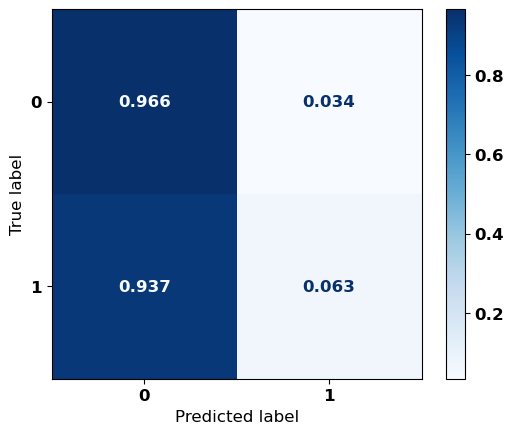


              precision    recall  f1-score   support

           0      0.267     0.966     0.418      2059
           1      0.841     0.063     0.118      5844

    accuracy                          0.298      7903
   macro avg      0.554     0.515     0.268      7903
weighted avg      0.691     0.298     0.196      7903



In [23]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

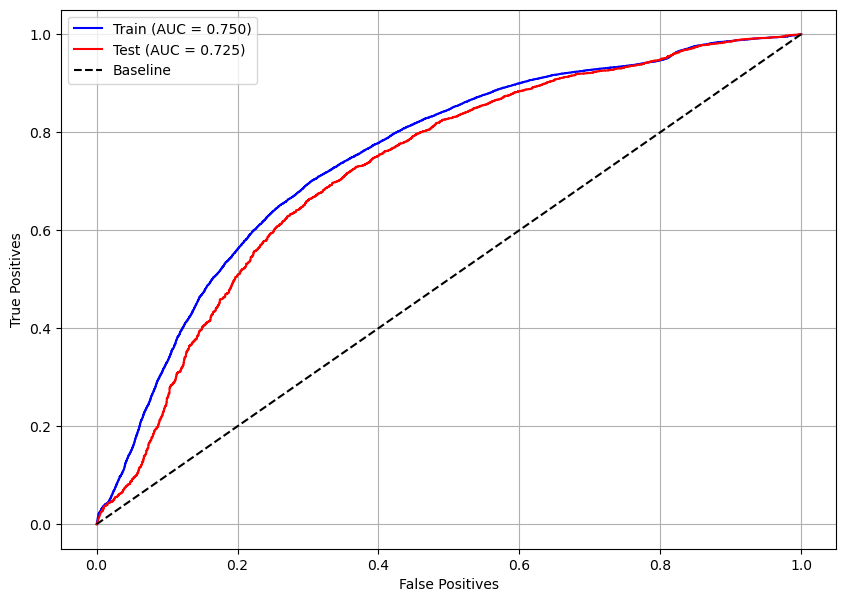

In [24]:
# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

- Pelas curvas ROC, pode-se dizer que não há overfitting, mas o modelo é ruim para a previsão da classe 1, portanto não seguiremos com análises, neste caso, com este modelo.

### **Random Forest**

O modelo Random Forest é mais complexo em relação ao Naive Bayes, assim alguns hiperparâmetros serão definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

-   `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável  `seed`.
    
-   `max_depth`: será definido como 8, pois o padrão do modelo é não ter profundidade máxima para as árvores, o que dificulta e faz o treinamento ser muito longo, além da maior chance de overfitting.
    
-   `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo, util no caso de classes desbalanceadas, aqui elas foram balanceadas previamente então vamos usar None

In [27]:
class_weights = {0: 1.25, 1: 1}  


rf = RandomForestClassifier(random_state=seed, 
                            class_weight=class_weights,
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 1.25, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

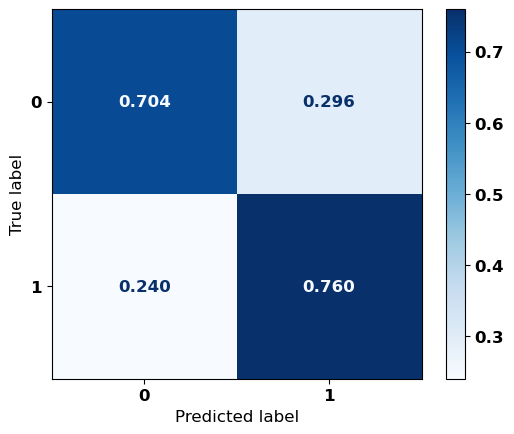


              precision    recall  f1-score   support

           0      0.508     0.704     0.590      2059
           1      0.879     0.760     0.815      5844

    accuracy                          0.745      7903
   macro avg      0.694     0.732     0.703      7903
weighted avg      0.783     0.745     0.756      7903



In [28]:
# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

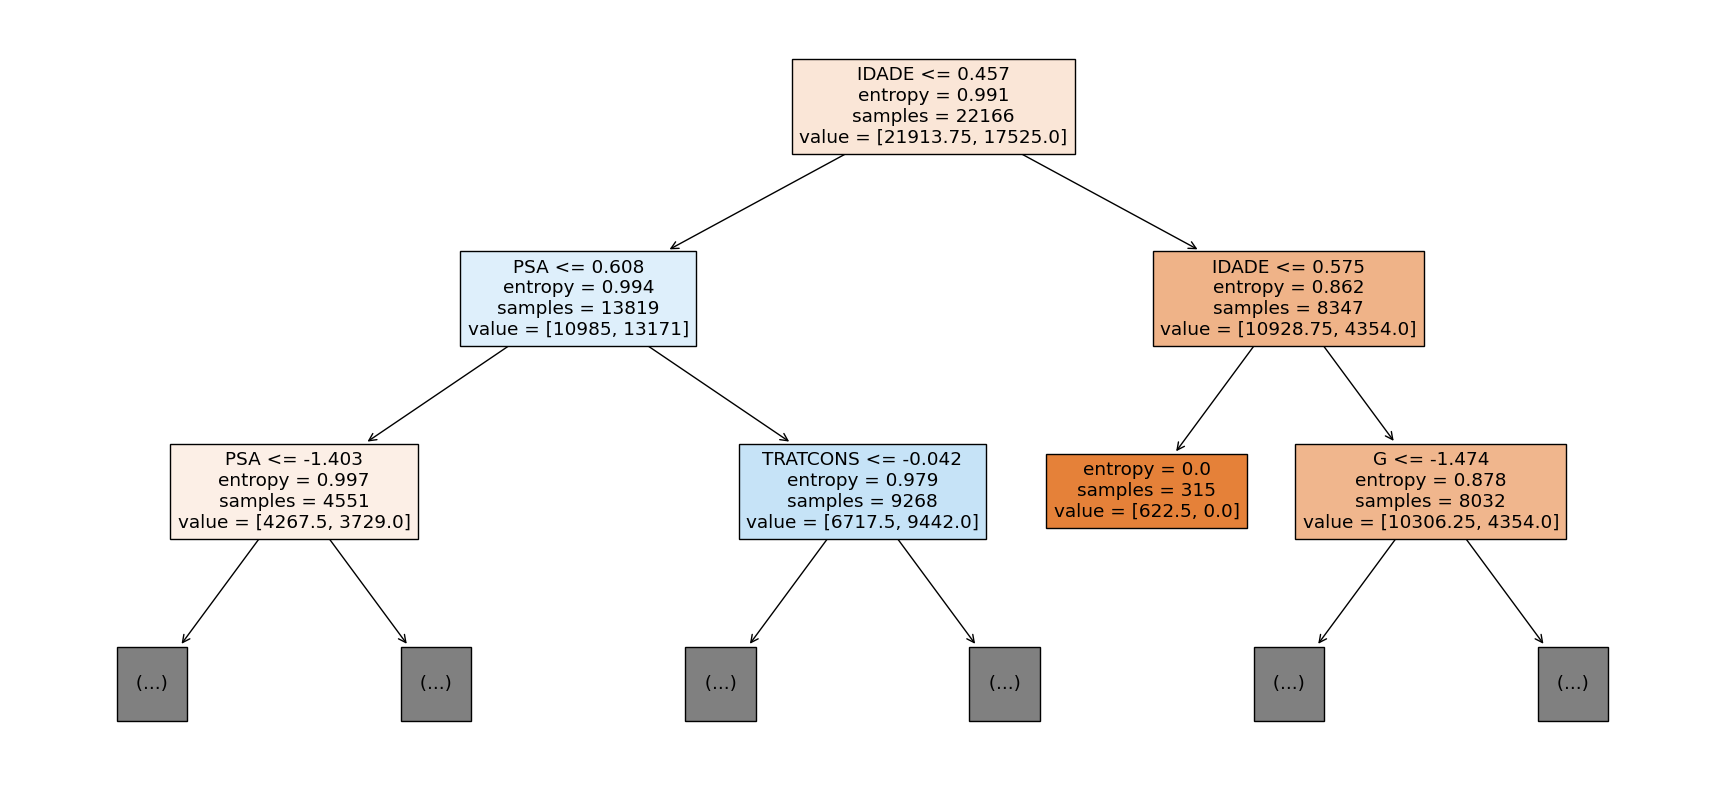

In [29]:
show_tree(rf, feat_cols, 2)

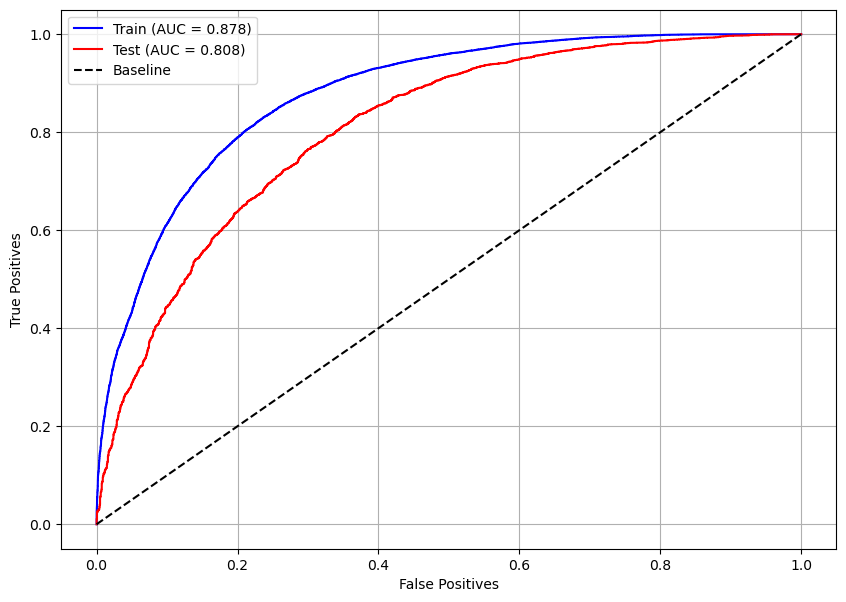

In [30]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

In [32]:
def plot_feat_importances(model, feat_cols, n=10):
    feat_import = pd.Series(model.feature_importances_, index=feat_cols)
    feat_import.nlargest(n).plot(kind='barh', figsize=(10, 8))
    plt.show()

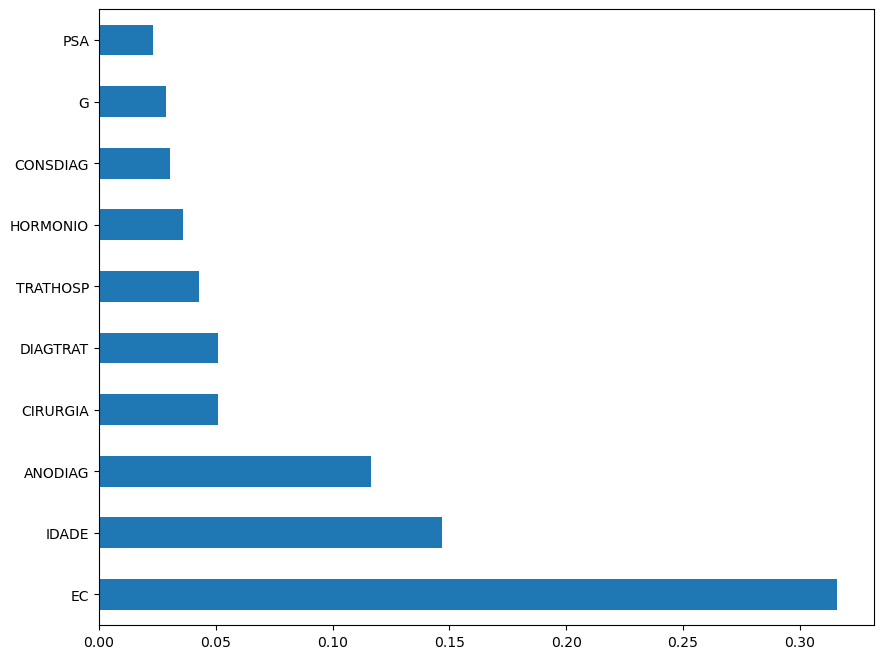

In [33]:
plot_feat_importances(rf, feat_cols)


> As features mais importantes nesta visualização são  `EC`, com uma grande vantagem,  `IDADE`,  `ANODIAG`  e  `CIRURGIA`.

#### Optuna

- Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [36]:
#Folds para validação (Scikit)
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [37]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples, 
                                 criterion=optimizer,
                                 random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()
     

In [38]:
# Criação do estudo e procura pelos hiperparâmetros
import warnings # Suprimir todos os warnings 
warnings.filterwarnings("ignore")
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100)

[I 2024-11-24 12:25:10,254] A new study created in memory with name: no-name-96c6105f-4fa3-415d-a585-d60cbef283ad
[I 2024-11-24 12:25:29,279] Trial 0 finished with value: 0.7408999607977973 and parameters: {'n_estimators': 205, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_samples': 0.7999999999999999, 'criterion': 'gini'}. Best is trial 0 with value: 0.7408999607977973.
[I 2024-11-24 12:26:04,795] Trial 1 finished with value: 0.7594142591825624 and parameters: {'n_estimators': 202, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_samples': 1.0, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7594142591825624.
[I 2024-11-24 12:27:12,551] Trial 2 finished with value: 0.8205731140614784 and parameters: {'n_estimators': 213, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_samples': 1.0, 'criterion': 'gini'}. Best is trial 2 with value: 0.8205731140614784.
[I 2024-11-24 12:27:27,836] Trial 3 finished with value: 0.7850299

In [39]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=80, state=1, values=[0.8510669901825182], datetime_start=datetime.datetime(2024, 11, 24, 13, 14, 4, 186768), datetime_complete=datetime.datetime(2024, 11, 24, 13, 14, 27, 368775), params={'n_estimators': 72, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=80, value=None)

In [40]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 72,
 'max_depth': 17,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.7,
 'criterion': 'gini'}

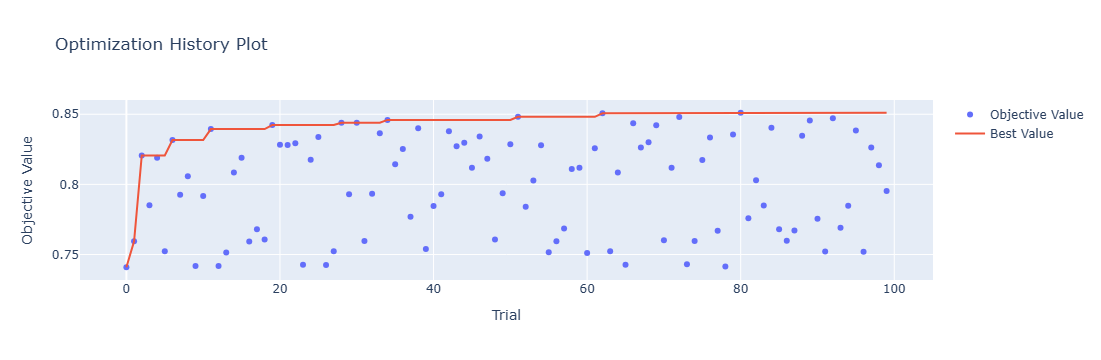

In [41]:
plot_optimization_history(studyRF).show()

In [ ]:
from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    # Usar F1-score para otimizar o equilíbrio entre TP e TN
    return f1_score(y_true, y_pred, average='weighted')

# Criar o custom scorer
scorer = make_scorer(custom_scorer, greater_is_better=True)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parâmetros para Grid Search
param_grid = {
    'class_weight': [{0: w0, 1: w1} for w0 in [1, 1.25, 1.5, 2] for w1 in [0.5, 1, 1.5]]
}

# Inicializar o RandomForestClassifier
rf = RandomForestClassifier(random_state=seed, max_depth=8, criterion='entropy')

# Configurar o Grid Search
grid_search = GridSearchCV(rf, param_grid, scoring=scorer, cv=skf)

# Executar o Grid Search
grid_search.fit(X_train, y_train)

# Obter e imprimir os melhores parâmetros
best_params = grid_search.best_params_

# Extraindo os melhores pesos das classes
best_class_weights = best_params['class_weight']
print(f"Os melhores pesos das classes são: {best_class_weights}")


In [117]:
from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

scorer = make_scorer(custom_scorer, greater_is_better=True)


In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parâmetros otimizados pelo Optuna
params = studyRF.best_params
params['random_state'] = seed

# Parâmetros para Grid Search - buscando melhores pesos das classes
param_grid = {
    'class_weight': [{0: w0, 1: w1} for w0 in [0.5, 1, 1.25, 1.5, 2] for w1 in [0.5, 1, 1.5]]
}

# Inicializar o RandomForestClassifier com parâmetros otimizados
rf_optuna = RandomForestClassifier(**params)

# Configurar o Grid Search
grid_search = GridSearchCV(rf_optuna, param_grid, scoring=scorer, cv=skf)

# Executar o Grid Search
grid_search.fit(X_train, y_train)

# Obter e imprimir os melhores parâmetros, incluindo os pesos das classes
best_params = grid_search.best_params_

# Extraindo os melhores pesos das classes
best_class_weights = best_params['class_weight']
print(f"Os melhores pesos das classes são: {best_class_weights}")

# Atualizar rf_optuna com os melhores pesos das classes
params['class_weight'] = best_class_weights
rf_optuna.set_params(**params)

# Treinar o modelo final com os melhores pesos das classes
rf_optuna.fit(X_train, y_train)


Os melhores pesos das classes são: {0: 2, 1: 1.5}


RandomForestClassifier(class_weight={0: 2, 1: 1.5}, max_depth=17,
                       max_samples=0.7, n_estimators=72, random_state=10)

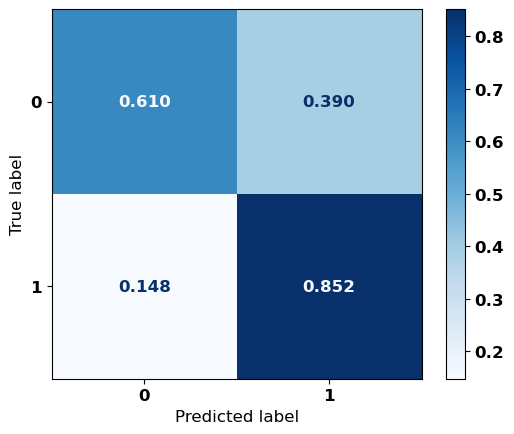


              precision    recall  f1-score   support

           0      0.592     0.610     0.601      2059
           1      0.861     0.852     0.857      5844

    accuracy                          0.789      7903
   macro avg      0.727     0.731     0.729      7903
weighted avg      0.791     0.789     0.790      7903



In [120]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

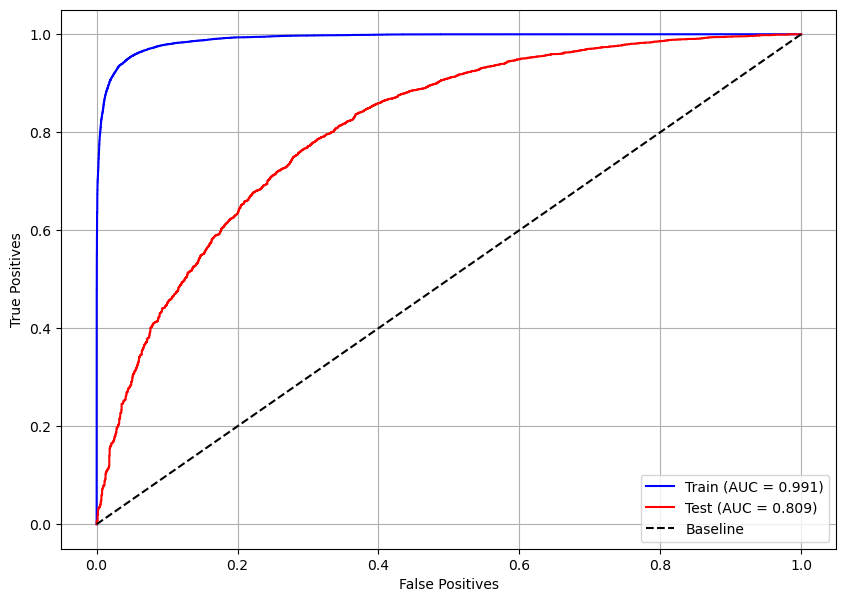

In [136]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

### **XGBoost**

O modelo XGBoost também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

-   `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável  `seed`.
    
-   `max_depth`: será utilizado o padrão, com valor 3.
    
-   `scale_pos_weight`: usado para definir o peso da classe 1 no treinamento do modelo, pois temos classes desbalanceadas.

In [45]:
# Criação e treinamento do modelo XGBoost 
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=1.25,
                    random_state=seed)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=10, ...)

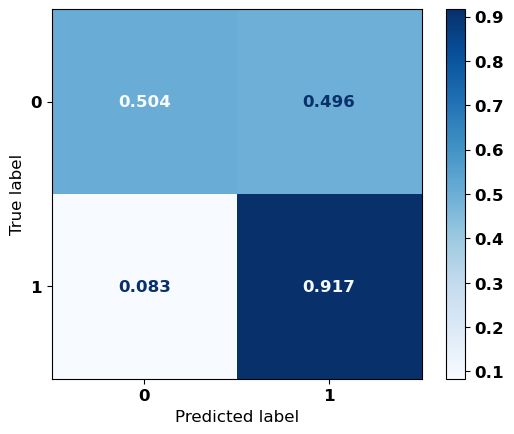


              precision    recall  f1-score   support

           0      0.681     0.504     0.579      2059
           1      0.840     0.917     0.877      5844

    accuracy                          0.809      7903
   macro avg      0.760     0.710     0.728      7903
weighted avg      0.798     0.809     0.799      7903



In [46]:
# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

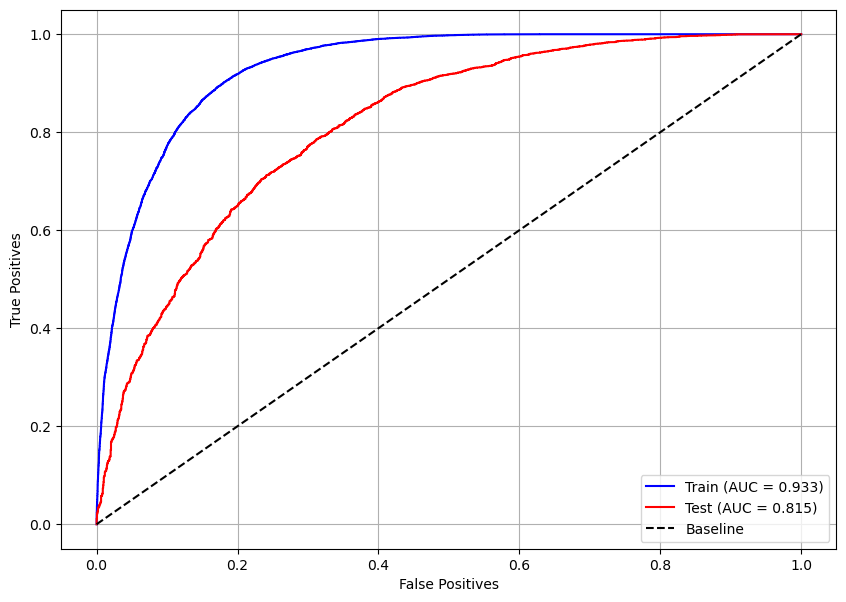

In [47]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

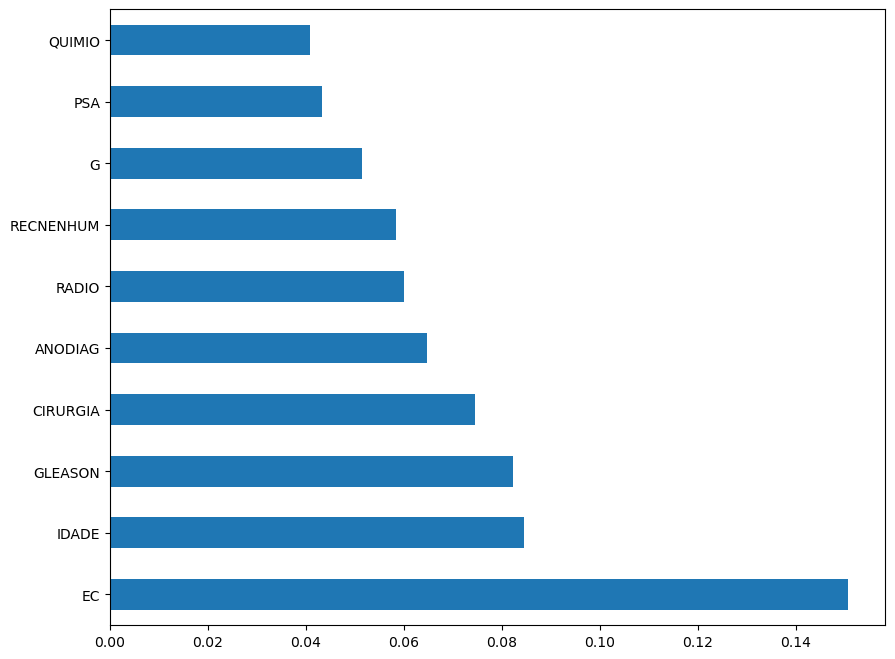

In [48]:
# Importância das features
plot_feat_importances(xgb, feat_cols)

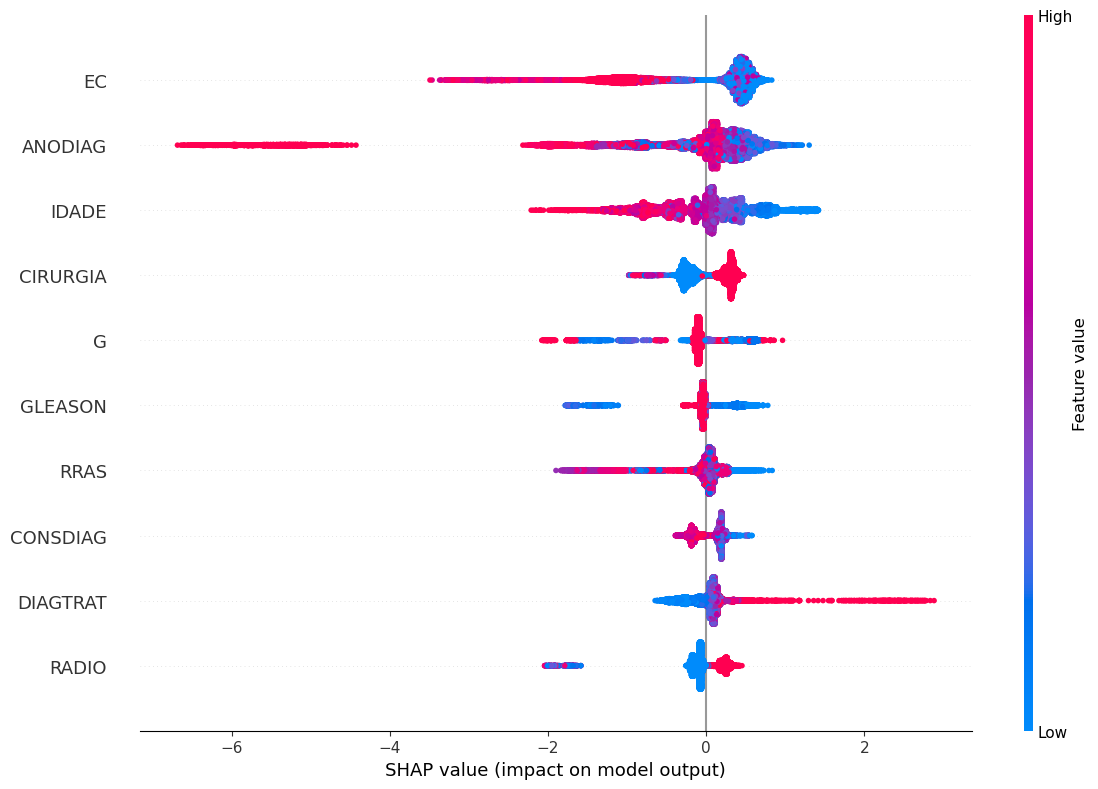

In [49]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### Optuna

- Para busca dos hiperparâmetros, mesmo processo que o feito para o Random Forest

In [51]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [52]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators, 
                        max_depth=max_depth, 
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight, 
                        colsample_bytree=colsample_bytree,
                        random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [53]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100)

[I 2024-11-24 13:26:31,721] A new study created in memory with name: no-name-d9d8900a-155d-4f71-9b6c-cabda6d59096
[I 2024-11-24 13:26:34,049] Trial 0 finished with value: 0.8545184282912267 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 4, 'colsample_bytree': 0.4}. Best is trial 0 with value: 0.8545184282912267.
[I 2024-11-24 13:26:45,605] Trial 1 finished with value: 0.8705218972303188 and parameters: {'n_estimators': 89, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.0, 'min_child_weight': 5, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.8705218972303188.
[I 2024-11-24 13:26:48,631] Trial 2 finished with value: 0.8736880937310337 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.2, 'gamma': 0.2, 'min_child_weight': 6, 'colsample_bytree': 0.4}. Best is trial 2 with value: 0.8736880937310337.
[I 2024-11-24 13:27:07,174] Trial 3 finished with value: 0.8765692765435379 and 

In [54]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=73, state=1, values=[0.8832160848851414], datetime_start=datetime.datetime(2024, 11, 24, 13, 35, 40, 200106), datetime_complete=datetime.datetime(2024, 11, 24, 13, 36, 2, 180819), params={'n_estimators': 107, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.0, 'min_child_weight': 1, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=73, value=None)

In [55]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 107,
 'max_depth': 16,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'min_child_weight': 1,
 'colsample_bytree': 0.6000000000000001}

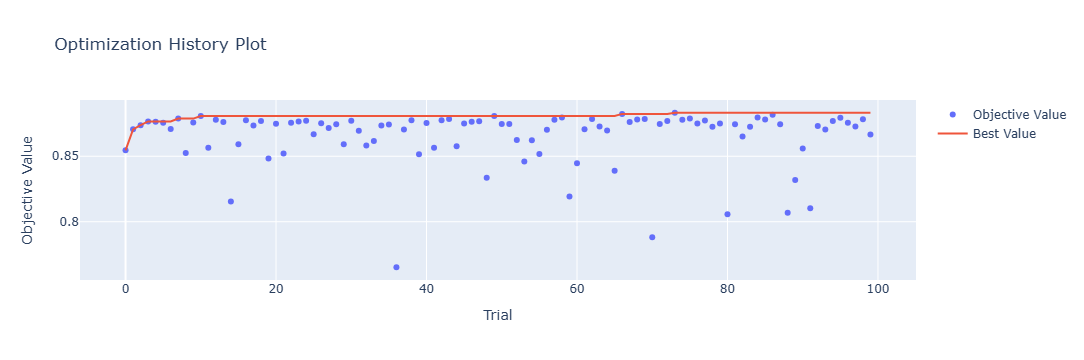

In [56]:
plot_optimization_history(studyXGB).show()

In [127]:
from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

scorer = make_scorer(custom_scorer, greater_is_better=True)


In [129]:
from sklearn.model_selection import GridSearchCV

# Parâmetros otimizados pelo Optuna
params = studyXGB.best_params
params['random_state'] = seed
# Parâmetros para Grid Search - buscando melhores pesos das classes
param_grid = {
    'scale_pos_weight': [0.5, 1, 1.25, 1.5, 2]  # Ajuste de pesos das classes
}

# Inicializar o XGBClassifier com parâmetros otimizados
xgb = XGBClassifier(**params)

# Configurar o Grid Search
grid_search = GridSearchCV(xgb, param_grid, scoring=scorer, cv=skf)

# Executar o Grid Search
grid_search.fit(X_train, y_train)

# Obter e imprimir os melhores parâmetros, incluindo os pesos das classes
best_params = grid_search.best_params_

# Atualizar o XGBClassifier com os melhores pesos das classes
params['scale_pos_weight'] = best_params['scale_pos_weight']
xgb.set_params(**params)

# Treinar o modelo final com os melhores pesos das classes
xgb.fit(X_train, y_train)

# Imprimir os melhores pesos das classes
print(f"Os melhores pesos das classes são: {params['scale_pos_weight']}")


Os melhores pesos das classes são: 1


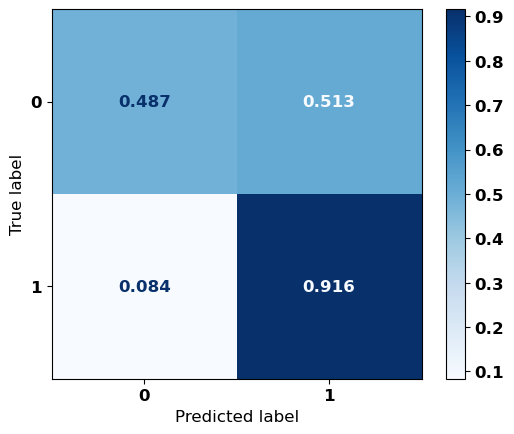


              precision    recall  f1-score   support

           0      0.672     0.487     0.565      2059
           1      0.835     0.916     0.874      5844

    accuracy                          0.804      7903
   macro avg      0.754     0.701     0.719      7903
weighted avg      0.793     0.804     0.793      7903



In [130]:
# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

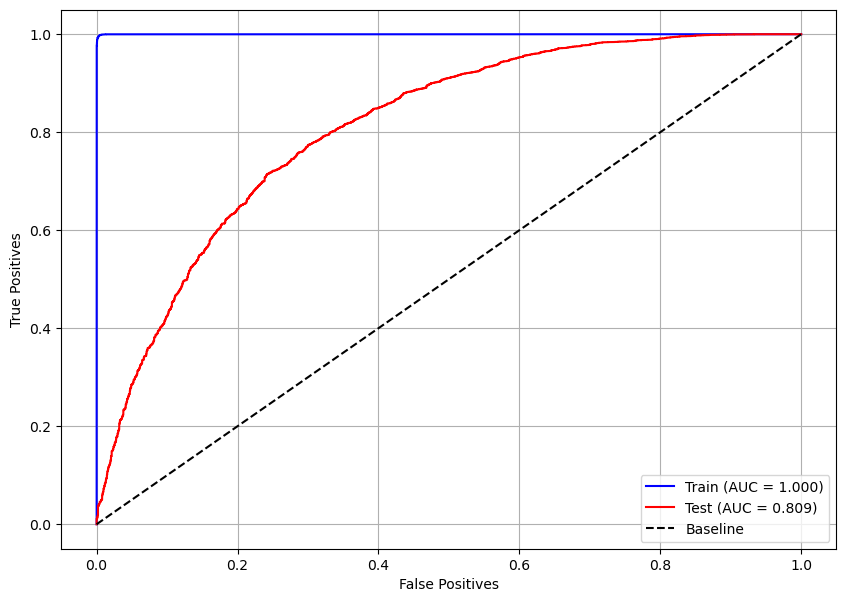

In [131]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

> Possível overfitting